# IA048A - EFC 03: Redes Neurais Artificiais

### Luís Antônio Almeida Lima Vieira (221045)  &  Nathan Shen Baldon (242448)

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 7.6 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=40accef4fbb60ddb6425f3211c10cd18237a01af084fa6cd4aeb3f70ed98346e
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 32.6 MB/s 
     |████████████████████████████████| 1.6 MB 48.2 MB/s 


In [ ]:
# É necessário antes de tudo instalar a biblioteca medmnist

# Importações necessárias
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os 
from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
import keras_tuner

# to make this notebook's output stable across runs
#np.random.seed(42) # indica onde escolha aleatória começa
SEED = 1984
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.config.experimental.enable_op_determinism()

# to make pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
EFC = "efc3"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", EFC)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="svg"):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension)

In [ ]:
# Verificando se a GPU foi conectada
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importação da base de dados BloodMNIST


In [ ]:
# Importando o dataset bloodmnist
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# carregando os dados
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [ ]:
info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

In [ ]:
# Separando os labels por conjunto:
train_labels = train_dataset.labels
val_labels = val_dataset.labels
test_labels = test_dataset.labels

In [ ]:
# Separando as imagens por conjunto:
train_img = train_dataset.imgs
val_img = val_dataset.imgs
test_img = test_dataset.imgs

In [ ]:
print(np.shape(train_img[0]))

(28, 28, 3)


Rótulo: [7] (Plaquetas)
Saving figure imagem_um


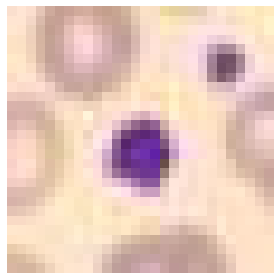

In [ ]:
# Vizualização da primeira imagem do conjunto de treinamento
print(f"Rótulo: {train_labels[0]} (Plaquetas)")
plt.imshow(train_img[0],cmap="gray")
plt.axis("off")
save_fig('imagem_um')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


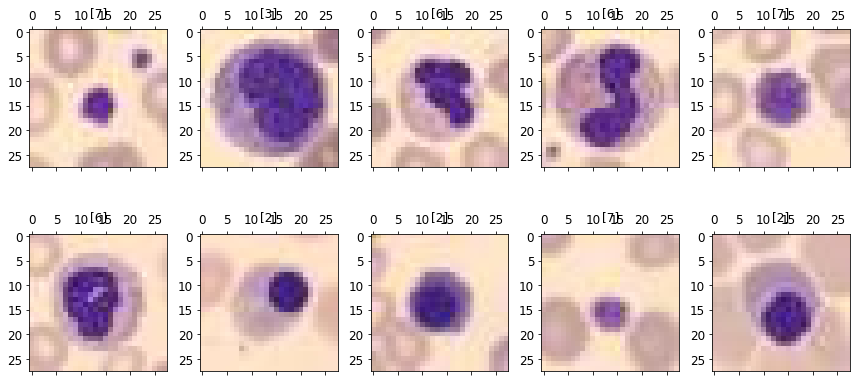

In [ ]:
# Vizualização das 10 primeiras imagens do conjunto de treinamento com seus respectivos labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(train_img[n])
        axs[i,j].set(title=train_labels[n])
        n=n+1
plt.show()

### Classes do conjunto


 Id | Rótulo                       |
--- |:--------------------------------:|
0  | Basófilos   |
1  | Eosinófilos |
2  | Eritroblastos   |
3  | Granulócitos imaturos   |
4  | Linfócitos   |
5  | Monócitos   |
6  | Neutrófilos   |
7  | Plaquetas   |


## Avaliação do conjunto de dados


In [ ]:
# Balanceamento do conjunto de treinamento
num_basofilos_t = (train_labels==0).sum()
num_eosinofilos_t = (train_labels==1).sum()
num_eritroblastos_t = (train_labels==2).sum()
num_granulocitos_t = (train_labels==3).sum()
num_linfocitos_t = (train_labels==4).sum()
num_monocitos_t = (train_labels==5).sum()
num_neutrofilos_t = (train_labels==6).sum()
num_plaquetas_t = (train_labels==7).sum()
p_basofilos_t = num_basofilos_t*100/len(train_labels)
p_eosinofilos_t = num_eosinofilos_t*100/len(train_labels)
p_eritroblastos_t = num_eritroblastos_t*100/len(train_labels)
p_granulocitos_t = num_granulocitos_t*100/len(train_labels)
p_linfocitos_t = num_linfocitos_t*100/len(train_labels)
p_monocitos_t = num_monocitos_t*100/len(train_labels)
p_neutrofilos_t = num_neutrofilos_t*100/len(train_labels)
p_plaquetas_t = num_plaquetas_t*100/len(train_labels)
print("No conjunto de treinamento há",num_basofilos_t, "Basófilos")
print("Porcentagem de classes 0:",p_basofilos_t ,"%")
print("No conjunto de treinamento há",num_eosinofilos_t, "Eosinófilos")
print("Porcentagem de classes 1:",p_eosinofilos_t,"%")
print("No conjunto de treinamento há",num_eritroblastos_t, "Eritroblastos")
print("Porcentagem de classes 2:",p_eritroblastos_t,"%")
print("No conjunto de treinamento há",num_granulocitos_t, "Granulócitos imaturos")
print("Porcentagem de classes 3:",p_granulocitos_t,"%")
print("No conjunto de treinamento há",num_linfocitos_t, "Linfócitos")
print("Porcentagem de classes 4:",p_linfocitos_t,"%")
print("No conjunto de treinamento há",num_monocitos_t, "Monócitos")
print("Porcentagem de classes 5:",p_monocitos_t,"%")
print("No conjunto de treinamento há",num_neutrofilos_t, "Neutrófilos")
print("Porcentagem de classes 6:",p_neutrofilos_t,"%")
print("No conjunto de treinamento há",num_plaquetas_t, "Plaquetas")
print("Porcentagem de classes 7:",p_plaquetas_t,"%")

No conjunto de treinamento há 852 Basófilos
Porcentagem de classes 0: 7.124341500125428 %
No conjunto de treinamento há 2181 Eosinófilos
Porcentagem de classes 1: 18.237310811940798 %
No conjunto de treinamento há 1085 Eritroblastos
Porcentagem de classes 2: 9.072664938540012 %
No conjunto de treinamento há 2026 Granulócitos imaturos
Porcentagem de classes 3: 16.941215820720796 %
No conjunto de treinamento há 849 Linfócitos
Porcentagem de classes 4: 7.099255790617945 %
No conjunto de treinamento há 993 Monócitos
Porcentagem de classes 5: 8.303369846977173 %
No conjunto de treinamento há 2330 Neutrófilos
Porcentagem de classes 6: 19.48323438414583 %
No conjunto de treinamento há 1643 Plaquetas
Porcentagem de classes 7: 13.738606906932018 %


In [ ]:
# Balanceamento do conjunto de validação
num_basofilos_v = (val_labels==0).sum()
num_eosinofilos_v = (val_labels==1).sum()
num_eritroblastos_v = (val_labels==2).sum()
num_granulocitos_v = (val_labels==3).sum()
num_linfocitos_v = (val_labels==4).sum()
num_monocitos_v = (val_labels==5).sum()
num_neutrofilos_v = (val_labels==6).sum()
num_plaquetas_v = (val_labels==7).sum()
p_basofilos_v = num_basofilos_v*100/len(val_labels)
p_eosinofilos_v = num_eosinofilos_v*100/len(val_labels)
p_eritroblastos_v = num_eritroblastos_v*100/len(val_labels)
p_granulocitos_v = num_granulocitos_v*100/len(val_labels)
p_linfocitos_v = num_linfocitos_v*100/len(val_labels)
p_monocitos_v = num_monocitos_v*100/len(val_labels)
p_neutrofilos_v = num_neutrofilos_v*100/len(val_labels)
p_plaquetas_v = num_plaquetas_v*100/len(val_labels)
print("No conjunto de validação há",num_basofilos_v, "Basófilos")
print("Porcentagem de classes 0:",p_basofilos_v ,"%")
print("No conjunto de validação há",num_eosinofilos_v, "Eosinófilos")
print("Porcentagem de classes 1:",p_eosinofilos_v,"%")
print("No conjunto de validação há",num_eritroblastos_v, "Eritroblastos")
print("Porcentagem de classes 2:",p_eritroblastos_v,"%")
print("No conjunto de validação há",num_granulocitos_v, "Granulócitos imaturos")
print("Porcentagem de classes 3:",p_granulocitos_v,"%")
print("No conjunto de validação há",num_linfocitos_v, "Linfócitos")
print("Porcentagem de classes 4:",p_linfocitos_v,"%")
print("No conjunto de validação há",num_monocitos_v, "Monócitos")
print("Porcentagem de classes 5:",p_monocitos_v,"%")
print("No conjunto de validação há",num_neutrofilos_v, "Neutrófilos")
print("Porcentagem de classes 6:",p_neutrofilos_v,"%")
print("No conjunto de validação há",num_plaquetas_v, "Plaquetas")
print("Porcentagem de classes 7:",p_plaquetas_v,"%")

No conjunto de validação há 122 Basófilos
Porcentagem de classes 0: 7.126168224299065 %
No conjunto de validação há 312 Eosinófilos
Porcentagem de classes 1: 18.22429906542056 %
No conjunto de validação há 155 Eritroblastos
Porcentagem de classes 2: 9.05373831775701 %
No conjunto de validação há 290 Granulócitos imaturos
Porcentagem de classes 3: 16.939252336448597 %
No conjunto de validação há 122 Linfócitos
Porcentagem de classes 4: 7.126168224299065 %
No conjunto de validação há 143 Monócitos
Porcentagem de classes 5: 8.352803738317757 %
No conjunto de validação há 333 Neutrófilos
Porcentagem de classes 6: 19.450934579439252 %
No conjunto de validação há 235 Plaquetas
Porcentagem de classes 7: 13.726635514018692 %


In [ ]:
# Balanceamento do conjunto de teste
num_basofilos_tt = (test_labels==0).sum()
num_eosinofilos_tt = (test_labels==1).sum()
num_eritroblastos_tt = (test_labels==2).sum()
num_granulocitos_tt = (test_labels==3).sum()
num_linfocitos_tt = (test_labels==4).sum()
num_monocitos_tt = (test_labels==5).sum()
num_neutrofilos_tt = (test_labels==6).sum()
num_plaquetas_tt = (test_labels==7).sum()
p_basofilos_tt = num_basofilos_tt*100/len(test_labels)
p_eosinofilos_tt = num_eosinofilos_tt*100/len(test_labels)
p_eritroblastos_tt = num_eritroblastos_tt*100/len(test_labels)
p_granulocitos_tt = num_granulocitos_tt*100/len(test_labels)
p_linfocitos_tt = num_linfocitos_tt*100/len(test_labels)
p_monocitos_tt = num_monocitos_tt*100/len(test_labels)
p_neutrofilos_tt = num_neutrofilos_tt*100/len(test_labels)
p_plaquetas_tt = num_plaquetas_tt*100/len(test_labels)
print("No conjunto de teste há",num_basofilos_tt, "Basófilos")
print("Porcentagem de classes 0:",p_basofilos_tt ,"%")
print("No conjunto de teste há",num_eosinofilos_tt, "Eosinófilos")
print("Porcentagem de classes 1:",p_eosinofilos_tt,"%")
print("No conjunto de teste há",num_eritroblastos_tt, "Eritroblastos")
print("Porcentagem de classes 2:",p_eritroblastos_tt,"%")
print("No conjunto de teste há",num_granulocitos_tt, "Granulócitos imaturos")
print("Porcentagem de classes 3:",p_granulocitos_tt,"%")
print("No conjunto de teste há",num_linfocitos_tt, "Linfócitos")
print("Porcentagem de classes 4:",p_linfocitos_tt,"%")
print("No conjunto de teste há",num_monocitos_tt, "Monócitos")
print("Porcentagem de classes 5:",p_monocitos_tt,"%")
print("No conjunto de teste há",num_neutrofilos_tt, "Neutrófilos")
print("Porcentagem de classes 6:",p_neutrofilos_tt,"%")
print("No conjunto de teste há",num_plaquetas_tt, "Plaquetas")
print("Porcentagem de classes 7:",p_plaquetas_tt,"%")

No conjunto de teste há 244 Basófilos
Porcentagem de classes 0: 7.1324174218064895 %
No conjunto de teste há 624 Eosinófilos
Porcentagem de classes 1: 18.240280619701842 %
No conjunto de teste há 311 Eritroblastos
Porcentagem de classes 2: 9.090909090909092 %
No conjunto de teste há 579 Granulócitos imaturos
Porcentagem de classes 3: 16.9248757673195 %
No conjunto de teste há 243 Linfócitos
Porcentagem de classes 4: 7.103186202864659 %
No conjunto de teste há 284 Monócitos
Porcentagem de classes 5: 8.301666179479684 %
No conjunto de teste há 666 Neutrófilos
Porcentagem de classes 6: 19.467991815258696 %
No conjunto de teste há 470 Plaquetas
Porcentagem de classes 7: 13.73867290266004 %


## Preparação do conjunto de dados


In [ ]:
# Dividindo os valores das imagens por 255, para manter a intensidade dos pixels com valores entre 0 e 1
x_train = train_img/255
x_valid = val_img/255
x_test = test_img/255
y_train = np.ravel(train_labels)
y_valid = np.ravel(val_labels)
y_test = np.ravel(test_labels)
# Criando o conjunto validação+treino para uso posterior
x_tv=np.concatenate((x_train,x_valid))
y_tv=np.concatenate((y_train,y_valid))
print("Formato do x_train: ", x_train.shape)
print("Formato do x_valid: ", x_valid.shape)
print("Formato do x_test: ", x_test.shape)
print("Formato do y_train: ", y_train.shape)
print("Formato do y_valid: ", y_valid.shape)
print("Formato do y_test: ", y_test.shape)
print("Valor máximo no treinamento: ", np.max(x_train))
print("Valor máximo no treinamento: ",np.min(x_train))

Formato do x_train:  (11959, 28, 28, 3)
Formato do x_valid:  (1712, 28, 28, 3)
Formato do x_test:  (3421, 28, 28, 3)
Formato do y_train:  (11959,)
Formato do y_valid:  (1712,)
Formato do y_test:  (3421,)
Valor máximo no treinamento:  1.0
Valor máximo no treinamento:  0.0


## MLP de **uma** camada intermediária



### Escolha dos hiperparâmetros (Keras Tuner)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# construção do modelo com hiperparâmetros variáveis a serem escohidos

def build_model_mlp1(hp):
  # definindo a MLP
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[28, 28, 3])) 
  # model.add(keras.layers.Dense(hp.Int("units", min_value=50, max_value=2000, step=200), activation="relu", 
  #                             kernel_regularizer=keras.regularizers.l1_l2(hp.Float("l1_l2", min_value=1e-15, max_value=1, sampling="log")))) # camada intermediária 
  model.add(keras.layers.Dense(hp.Int("units", min_value=100, max_value=2000, step=200), activation="relu"))#, kernel_regularizer=keras.regularizers.l1_l2(.01))) # camada intermediária com número de neurônios variável
  model.add(keras.layers.Dense(8, activation="softmax")) # camada de saída
  learning_rate = hp.Float("lr", min_value=5e-4, max_value=3e-2, sampling="log") # learning rate variável
  # compila o modelo de MLP criado
  model.compile(loss="sparse_categorical_crossentropy", 
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
  return model

build_model_mlp1(keras_tuner.HyperParameters())

# definicão do tuner para busca de hiperparâmetros (testa 10 combinações diferentes e procura melhorar acurácia na validação)
tuner1 = keras_tuner.BayesianOptimization(
    hypermodel=build_model_mlp1,
    objective="val_accuracy",
    max_trials=10, 
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True
)

print(tuner1.search_space_summary())  # resumo do conjunto de hiperparâmetros possíveis

# busca do melhor conjunto de hiperparâmetros 
tuner1.search(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)])

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.832359790802002

Best val_accuracy So Far: 0.860397219657898
Total elapsed time: 00h 11m 42s


Ajustes realizados:
* número de neurônios (100, 300 e 1500)
* class_weight (balanced, None)
* optimizer, learning rate (.01)
* função de ativação (relu, selu e sigmoid)
* métrica otimizada (accuracy)
* função custo 
* kernels inicializados aleatoriamentes (padrão da função Dense() do Keras)
* número de épocas (50, 100 e 200)





In [ ]:
# Get the top 2 models.
models = tuner1.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 1900)              4470700   
                                                                 
 dense_1 (Dense)             (None, 8)                 15208     
                                                                 
Total params: 4,485,908
Trainable params: 4,485,908
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner1.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 1900
lr: 0.0005
Score: 0.860397219657898
Trial summary
Hyperparameters:
units: 1300
lr: 0.0005
Score: 0.8598130941390991
Trial summary
Hyperparameters:
units: 1700
lr: 0.0005
Score: 0.8568925261497498
Trial summary
Hyperparameters:
units: 900
lr: 0.0005
Score: 0.8376168012619019
Trial summary
Hyperparameters:
units: 100
lr: 0.0005
Score: 0.8370327353477478
Trial summary
Hyperparameters:
units: 100
lr: 0.0030300720194418266
Score: 0.8329439163208008
Trial summary
Hyperparameters:
units: 1900
lr: 0.0005
Score: 0.832359790802002
Trial summary
Hyperparameters:
units: 1900
lr: 0.0007760377858074776
Score: 0.8317757248878479
Trial summary
Hyperparameters:
units: 500
lr: 0.003071051052591078
Score: 0.826518714427948
Trial summary
Hyperparameters:
units: 900
lr: 0.011325479096718077
Score: 0.7435747385025024


Sobre o modelo:
* loss: SparseCategoricalCrossentropy, pois é a recomendada para o cenário com mais de 2 classe em que as classes são representadas por números inteiros (ref: https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)
* função de ativação RELu foi a escolha inicial por sua popularidade e foi a que apresentou melhor acurácia nos testes iniciais
* camada Flatten preprocessa os dados de entrada, deixando-os em formato de uma dimensão
* camada Dense: 
* camada de saída: composta por 8 neurônios, cada um representando uma possível classe. A função de ativação escolhida foi a softmax, devido ao cenário ser de multi-classe em que deseja-se inferir apenas a classe que a amostra pertence. 

In [ ]:
keras.utils.plot_model(model_MLP1, "MLP_1L_model.png", show_shapes=True)

NameError: ignored

### Treinamento e Teste - MLP1

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


mlp1 = keras.models.Sequential()
mlp1.add(keras.layers.Flatten(input_shape=[28, 28, 3])) 
# model.add(keras.layers.Dense(hp.Int("units", min_value=50, max_value=2000, step=200), activation="relu", 
#                             kernel_regularizer=keras.regularizers.l1_l2(hp.Float("l1_l2", min_value=1e-15, max_value=1, sampling="log")))) # camada intermediária 
mlp1.add(keras.layers.Dense(1900, activation="relu"))#, kernel_regularizer=keras.regularizers.l1_l2(.01))) # camada intermediária com número de neurônios variável
mlp1.add(keras.layers.Dense(8, activation="softmax")) # camada de saída
learning_rate = 0.0005
# compila o modelo de MLP criado
mlp1.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])

# calcula os pesos de cada classe para balanceamento no treinamento
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))



In [ ]:
history = mlp1.fit(x_tv, y_tv, epochs=100,
                    validation_data=(x_valid, y_valid))#, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)])#, class_weight=class_weights)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

mlp1.evaluate(x_test, y_test)

Epoch 1/100
428/428 [==============================] - 3s 5ms/step - loss: 1.3556 - accuracy: 0.5417 - val_loss: 1.0227 - val_accuracy: 0.5923
Epoch 2/100
428/428 [==============================] - 2s 5ms/step - loss: 0.8887 - accuracy: 0.6830 - val_loss: 0.7999 - val_accuracy: 0.6852
Epoch 3/100
428/428 [==============================] - 2s 5ms/step - loss: 0.7998 - accuracy: 0.7164 - val_loss: 0.6883 - val_accuracy: 0.7605
Epoch 4/100
428/428 [==============================] - 2s 5ms/step - loss: 0.7610 - accuracy: 0.7293 - val_loss: 0.7420 - val_accuracy: 0.6893
Epoch 5/100
428/428 [==============================] - 2s 5ms/step - loss: 0.6901 - accuracy: 0.7518 - val_loss: 0.7194 - val_accuracy: 0.7144
Epoch 6/100
428/428 [==============================] - 2s 5ms/step - loss: 0.6411 - accuracy: 0.7714 - val_loss: 0.5641 - val_accuracy: 0.7926
Epoch 7/100
428/428 [==============================] - 2s 5ms/step - loss: 0.6049 - accuracy: 0.7864 - val_loss: 0.5711 - val_accuracy: 0.7833

In [ ]:
# exibe a probabilidade estimada de cada classe para as três primeiras amostras do conjunto de teste
x_new = x_test[:3]
y_proba_MLP1 = mlp1.predict(x_new)
print(y_proba_MLP1.round(2))

y_pred_MLP1 = np.argmax(mlp1.predict(x_test), axis=-1) # indica classe com maior probabilidade
print(y_pred_MLP1[:3])
print(y_test[:3])

1/1 [==============================] - 0s 81ms/step
[[0.   0.   0.01 0.01 0.   0.98 0.   0.  ]
 [0.92 0.08 0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]]
107/107 [==============================] - 0s 2ms/step
[5 0 1]
[3 0 1]


### Acurácia


In [ ]:
# Resumo do modelo
print("Model summary")
mlp1.summary() # print model summary
print("")

# Model Evaluation
print("Model Evaluation")
MLP1_test = mlp1.evaluate(x_test, y_test)
print("A acurácia global para os dados de teste obtida foi de 0.8427")

Model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 1900)              4470700   
                                                                 
 dense_1 (Dense)             (None, 8)                 15208     
                                                                 
Total params: 4,485,908
Trainable params: 4,485,908
Non-trainable params: 0
_________________________________________________________________

Model Evaluation
107/107 [==============================] - 0s 3ms/step - loss: 0.4579 - accuracy: 0.8436
A acurácia global para os dados de teste obtida foi de 0.8427


### Matriz de confusão

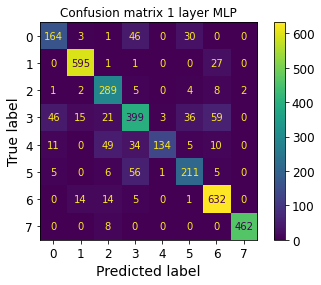

In [ ]:
# Matriz de confusão
MLP1_cm=metrics.confusion_matrix(y_test, y_pred_MLP1)
cm_fig=metrics.ConfusionMatrixDisplay(confusion_matrix=MLP1_cm)
cm_fig.plot()
plt.title('Confusion matrix 1 layer MLP')
plt.show()

## MLP de **duas** camadas intermediárias

### Escolha dos hiperparâmetros (Keras Tuner)


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def MLP2(units1, units2, activation, lr, dropout):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28, 3]))
    model.add(keras.layers.Dense(units=units1, activation=activation))
    model.add(keras.layers.Dense(units=units2, activation=activation))
    if dropout:
        model.add(keras.layers.Dropout(rate=0.25))
    model.add(keras.layers.Dense(8, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=["accuracy"])
    return model

def build_model_MLP2(hp):
    units1 = hp.Int("units1", min_value=200, max_value=2000, step=200)
    units2 = hp.Int("units2", min_value=200, max_value=2000, step=200)
    activation = hp.Choice("activation", ["relu"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = MLP2(units1=units1, units2=units2, activation=activation, lr=lr, dropout=dropout)
    return model

build_model_MLP2(keras_tuner.HyperParameters())

tuner_mlp2 = keras_tuner.BayesianOptimization(
    hypermodel=build_model_MLP2,
    objective="val_accuracy",
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True
)

print(tuner_mlp2.search_space_summary())

tuner_mlp2.search(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid))

# Get the top 2 models.
models = tuner_mlp2.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Trial 3 Complete [00h 04m 23s]
val_accuracy: 0.889602780342102

Best val_accuracy So Far: 0.8966121673583984
Total elapsed time: 00h 12m 15s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
2000              |1800              |units1
200               |600               |units2
relu              |relu              |activation
True              |True              |dropout
0.0001            |0.00012105        |lr

Epoch 1/100
374/374 [==============================] - 3s 6ms/step - loss: 1.3859 - accuracy: 0.4765 - val_loss: 1.0741 - val_accuracy: 0.6197
Epoch 2/100
374/374 [==============================] - 2s 6ms/step - loss: 1.0148 - accuracy: 0.6293 - val_loss: 0.8689 - val_accuracy: 0.6986
Epoch 3/100
374/374 [==============================] - 2s 6ms/step - loss: 0.8973 - accuracy: 0.6774 - val_loss: 0.7302 - val_accuracy: 0.7453
Epoch 4/100
374/374 [==============================] - 2s 6ms/step - loss: 0.8351 - accuracy: 0.7004 - val_loss: 0.6924 - v

In [ ]:
tuner3 = keras_tuner.BayesianOptimization(
    hypermodel=build_model_t,
    objective="val_accuracy",
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True
)
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 2000, 'step': 200, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 2000, 'step': 200, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0005, 'conditions': [], 'min_value': 0.0005, 'max_value': 0.05, 'step': None, 'sampling': 'log'}


In [ ]:
tuner3.search(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid))

In [ ]:
# Get the top 2 models.
models = tuner3.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 1900)              4470700   
                                                                 
 dense_1 (Dense)             (None, 500)               950500    
                                                                 
 dense_2 (Dense)             (None, 8)                 4008      
                                                                 
Total params: 5,425,208
Trainable params: 5,425,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner3.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 900
units2: 1100
dropout: False
lr: 0.016715609381530536
Score: 0.8825934529304504
Trial summary
Hyperparameters:
units1: 500
units2: 1900
dropout: False
lr: 0.05
Score: 0.8814252614974976
Trial summary
Hyperparameters:
units1: 1700
units2: 500
dropout: False
lr: 0.05
Score: 0.8755841255187988
Trial summary
Hyperparameters:
units1: 500
units2: 1900
dropout: True
lr: 0.05
Score: 0.8732476830482483
Trial summary
Hyperparameters:
units1: 500
units2: 500
dropout: False
lr: 0.05
Score: 0.8714953064918518
Trial summary
Hyperparameters:
units1: 500
units2: 500
dropout: True
lr: 0.05
Score: 0.8685747385025024
Trial summary
Hyperparameters:
units1: 1700
units2: 1900
dropout: False
lr: 0.001251932070183275
Score: 0.8358644843101501
Trial summary
Hyperparameters:
units1: 500
units2: 500
dropout: False
lr: 0.0005
Score: 0.8136682510375977
Trial summary
Hyperparameters:
units1: 500
units2: 19

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner3.get_best_hyperparameters(5)
# Build the model with the best hp.
print(best_hps)

[<keras_tuner.engine.hyperparameters.HyperParameters object at 0x7fdc49e53ed0>, <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7fdc54047e90>, <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7fdc552d0d50>, <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7fdc541aa510>, <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7fdc54050790>]


* Tentativa de usar RandomizedSearchCV:


In [ ]:
# funções para criação de modelo sem parâmetros fixos

def build_model(n_hidden, n_neurons, learning_rate, input_shape=[28,28,3]):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    #model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
  return model

def build_model2(n_neurons, learning_rate, input_shape=[28,28,3]):
  # definindo a MLP
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[28, 28, 3])) 
  model.add(keras.layers.Dense(n_neurons, activation="relu")) # camada intermediária 
  model.add(keras.layers.Dense(n_neurons, activation="relu")) # camada intermediária 
  model.add(keras.layers.Dense(8, activation="softmax")) # camada de saída
  # compila o modelo de MLP criado
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=0.01),
                metrics=["accuracy"])
  return model

# criação do modelo e realização da validação cruzada 
model_MLP2 = keras.wrappers.scikit_learn.KerasClassifier(build_model2)

from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV

param_distribs = {"n_neurons": [100, 1500], "learning_rate": [3e-4,3e-2]}

grid_search_cv = GridSearchCV(model_MLP2, param_distribs, cv=3, verbose=2, scoring='accuracy')
cv_fit = grid_search_cv.fit(x_train, y_train, epochs=200, validation_data=(x_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
cv_fit.best_params_
cv_fit.best_score_



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/200
250/250 [==============================] - 2s 5ms/step - loss: 1.5523 - accuracy: 0.4131 - val_loss: 1.4407 - val_accuracy: 0.4439
Epoch 2/200
250/250 [==============================] - 1s 4ms/step - loss: 1.2376 - accuracy: 0.5231 - val_loss: 1.8304 - val_accuracy: 0.2541
Epoch 3/200
250/250 [==============================] - 1s 4ms/step - loss: 1.1014 - accuracy: 0.5827 - val_loss: 1.3402 - val_accuracy: 0.4393
Epoch 4/200
250/250 [==============================] - 1s 4ms/step - loss: 1.0127 - accuracy: 0.6205 - val_loss: 1.5091 - val_accuracy: 0.3995
Epoch 5/200
124/250 [=============>................] - ETA: 0s - loss: 0.9667 - accuracy: 0.6472

KeyboardInterrupt: ignored

### Treinamento e Teste

Epoch 1/100
374/374 [==============================] - 6s 6ms/step - loss: 1.1810 - accuracy: 0.5730 - val_loss: 0.8932 - val_accuracy: 0.6834
Epoch 2/100
374/374 [==============================] - 3s 7ms/step - loss: 0.8453 - accuracy: 0.7067 - val_loss: 0.7812 - val_accuracy: 0.7412
Epoch 3/100
374/374 [==============================] - 2s 5ms/step - loss: 0.7546 - accuracy: 0.7341 - val_loss: 0.6652 - val_accuracy: 0.7716
Epoch 4/100
374/374 [==============================] - 2s 5ms/step - loss: 0.6963 - accuracy: 0.7509 - val_loss: 0.6077 - val_accuracy: 0.7763
Epoch 5/100
374/374 [==============================] - 2s 5ms/step - loss: 0.6478 - accuracy: 0.7668 - val_loss: 0.7168 - val_accuracy: 0.7313
Epoch 6/100
374/374 [==============================] - 2s 5ms/step - loss: 0.6159 - accuracy: 0.7777 - val_loss: 0.5478 - val_accuracy: 0.7932
Epoch 7/100
374/374 [==============================] - 2s 5ms/step - loss: 0.5703 - accuracy: 0.7962 - val_loss: 0.6280 - val_accuracy: 0.7664

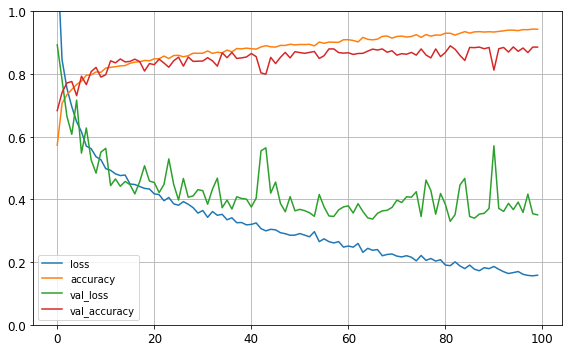

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

mlp2 = keras.models.Sequential()
mlp2.add(keras.layers.Flatten(input_shape=[28, 28, 3])) 
mlp2.add(keras.layers.Dense(1900, activation="relu")) # camada intermediária 
mlp2.add(keras.layers.Dense(500, activation="relu")) # camada intermediária 
#mlp2.add(keras.layers.Dropout(rate=0.25))
mlp2.add(keras.layers.Dense(8, activation="softmax")) # camada de saída
learning_rate =.0001
# compila o modelo de MLP criado
mlp2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])

history = mlp2.fit(x_train, y_train, epochs=100,
                    validation_data=(x_valid, y_valid))#, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)])

mlp2.evaluate(x_test, y_test)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()


In [ ]:
cv_fit.best_params_

NameError: ignored

Saving figure keras_learning_curves_plot


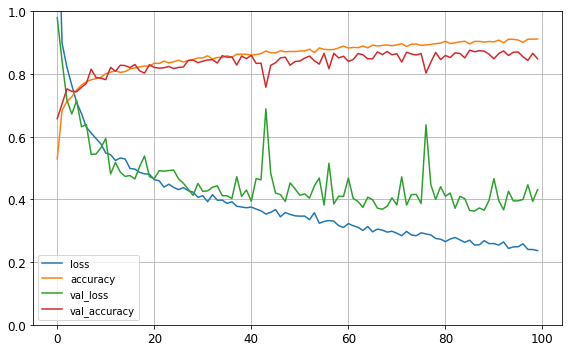

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
# definindo a MLP
model_MLP2 = keras.models.Sequential()
model_MLP2.add(keras.layers.Flatten(input_shape=[28, 28, 3]))
model_MLP2.add(keras.layers.Dense(1500, activation="relu")) # camada intermediária
model_MLP2.add(keras.layers.Dense(1500, activation="relu")) # camada intermediária
model_MLP2.add(keras.layers.Dense(8, activation="softmax")) # camada de saída

#model_MLP2.summary() # resume o formato da MLP

# compila o modelo de MLP criado
model_MLP2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

In [ ]:
model_MLP2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense_4 (Dense)             (None, 300)               705900    
                                                                 
 dense_5 (Dense)             (None, 300)               90300     
                                                                 
 dense_6 (Dense)             (None, 8)                 2408      
                                                                 
Total params: 798,608
Trainable params: 798,608
Non-trainable params: 0
_________________________________________________________________


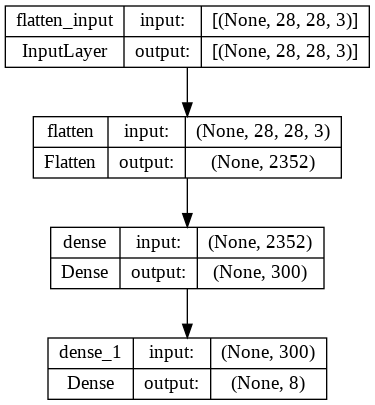

In [ ]:
keras.utils.plot_model(model_MLP1, "MLP_2L_model.png", show_shapes=True)

In [ ]:
#model_MLP2 = keras.wrappers.scikit_learn.KerasClassifier(build_model(2, 200,.005))
model_MLP2 = build_model2(200,.01)
print(model_MLP2.summary())

model_MLP2.fit(x_train, y_train, epochs=100,
              validation_data=(x_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_7 (Dense)             (None, 200)               470600    
                                                                 
 dense_8 (Dense)             (None, 200)               40200     
                                                                 
 dense_9 (Dense)             (None, 8)                 1608      
                                                                 
Total params: 512,408
Trainable params: 512,408
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


None
Epoch 1/100
374/374 [==============================] - 2s 4ms/step - loss: 1.4293 - accuracy: 0.4513 - val_loss: 1.1029 - val_accuracy: 0.5888
Epoch 2/100
374/374 [==============================] - 2s 4ms/step - loss: 1.1055 - accuracy: 0.5859 - val_loss: 1.0312 - val_accuracy: 0.6069
Epoch 3/100
374/374 [==============================] - 2s 4ms/step - loss: 0.9995 - accuracy: 0.6261 - val_loss: 1.1153 - val_accuracy: 0.5234
Epoch 4/100
 15/374 [>.............................] - ETA: 1s - loss: 0.9057 - accuracy: 0.6708

KeyboardInterrupt: ignored

In [ ]:
# exibe a probabilidade estimada de cada classe para as três primeiras amostras do conjunto de teste
x_new = x_test[:3]
y_proba_MLP2 = model_MLP2.predict(x_new)
print(y_proba_MLP2.round(2))

y_pred_MLP2 = np.argmax(model_MLP2.predict(x_test), axis=-1) # indica classe com maior probabilidade
print(y_pred_MLP2[:3])
print(y_test[:3])

In [ ]:
# Resumo do modelo
print("Model summary")
model_MLP2.summary() # print model summary
print("")

# Model Evaluation
print("Model Evaluation")
MLP2_test = model_MLP2.evaluate(x_test, y_test)
print("A acurácia global para os dados de teste obtida foi de 0.8427")

In [ ]:
# Matriz de confusão
MLP2_cm=metrics.confusion_matrix(y_test, y_pred_MLP2)
cm_fig=metrics.ConfusionMatrixDisplay(confusion_matrix=MLP2_cm)
cm_fig.plot()
plt.title('Confusion matrix 2 layer MLP')
plt.show()

## Treinamento e validação da CNN Simples

- Avaliação da influência do número de Kernels na Acurária dos dados de validação:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 1


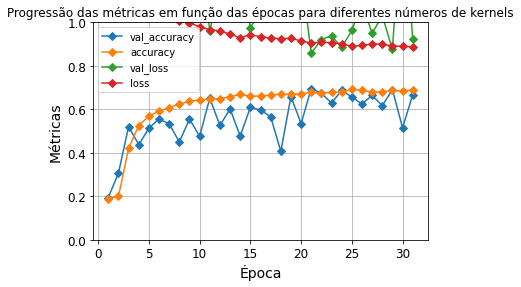

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 5


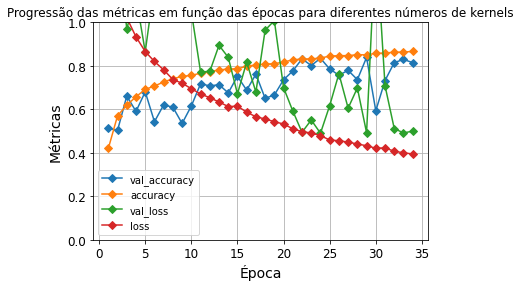

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 10


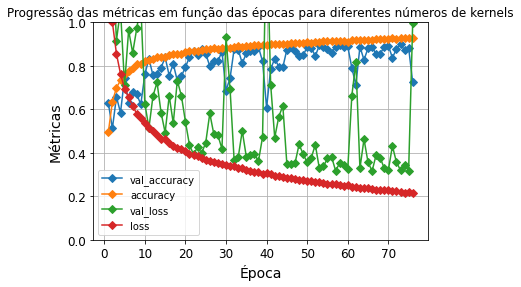

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 15


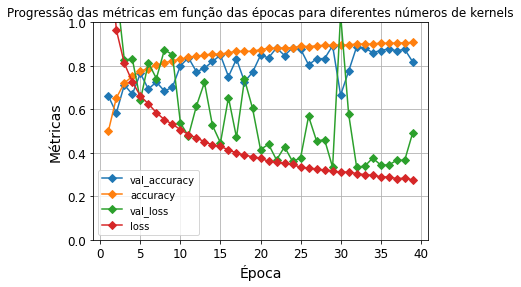

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 20


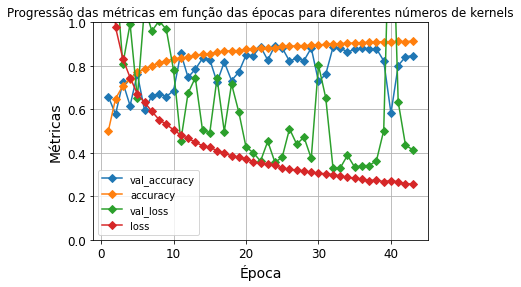

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 30


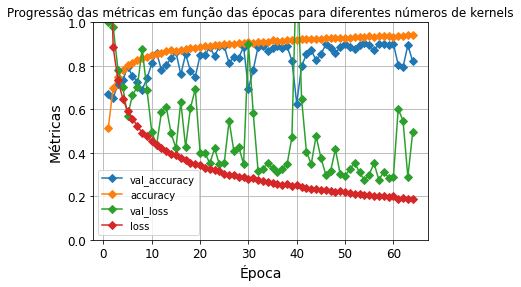

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 40


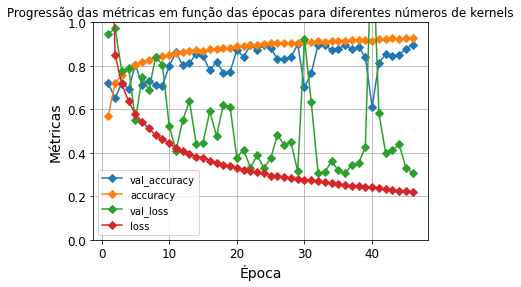

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 50


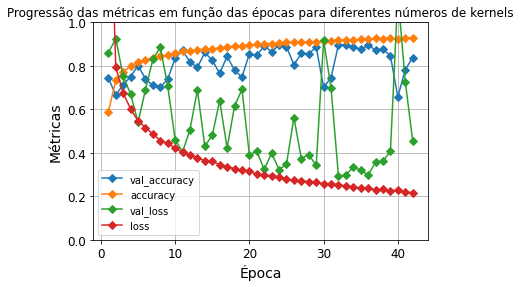

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 100


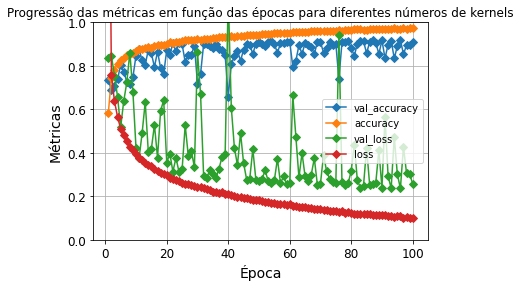

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 150


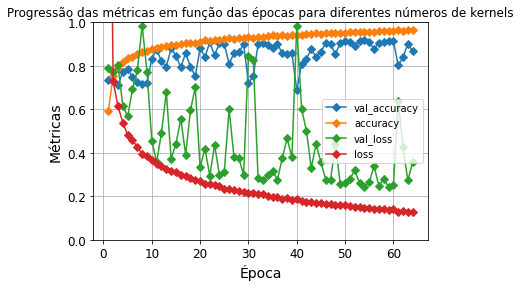

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 200


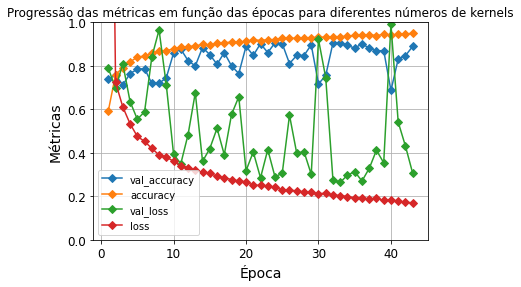

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 250


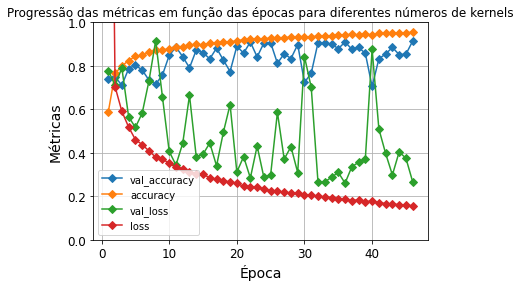

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 350


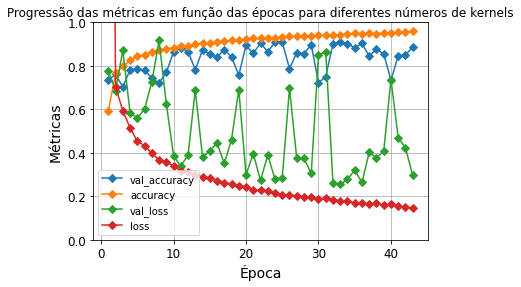

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 500


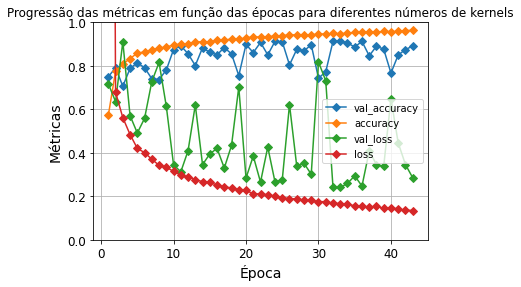

In [ ]:
# Primeiro será feito o treinamento fixando todos os parâmetros e variando o número de kernels
# Valores de número de kernels a serem testados:
n_kernels = [1,5,10,15,20,30,40,50,100,150,200,250,350,500]
# Vetor das melhores acurácias de validação
best_val_acc = []
best_val_loss = []
# Vetor das respectivas épocas das melhores acurácias
best_epoch_acc= []
best_epoch_loss= []
for i in np.arange(0,len(n_kernels),1):
  # Construção da CNN
  # definindo o modelo:
  sCNN_model = keras.models.Sequential()
  # Definição da camada convolucional:
  sCNN_model.add(keras.layers.Conv2D(
                  # Será testado pelo KerasTuner diferentes quantidades de kernels
                  filters= int(n_kernels[i]), # Número de Kernels 
                  kernel_size=(3,3), # Tamanho dos kernels fixado em 3x3
                  strides=(1,1), # Stride unitário ao logo das duas dimensões da imagem (imagem com poucos pixels)
                  input_shape=[28, 28, 3], # Formato das imagens de entrada [linhas, colunas, canais]
                  padding='same', # Default='valid',"same" faz o zero padding e quando o stride é unitário mantém as dimensões da imagem
                  data_format=None, # Default=None, canais por último no formato de entrada
                  dilation_rate=(1, 1), # Default=(1, 1), sem dilatação da convolução
                  groups=1, # Default=1, apenas um grupo para as entradas
                  activation='relu', # Função de ativação ReLu
                  use_bias=True, # Default=True. Utilizando bias no modelo
                  kernel_initializer='he_uniform', # Default='glorot_uniform'. Modo de inicialização do pesos definido como he_uniform
                  bias_initializer='zeros', # Default='zeros'. Inicia o bias como zero
                  kernel_regularizer=None, # Default=None. Não utiliza regularização
                  bias_regularizer=None, # Default=None. Não utiliza regularização do bias 
                  activity_regularizer=None, # Default=None. Sem função de regularização na saída
                  kernel_constraint=None, # Default=None. Sem Constraint function (definições para os valores dos pesos) no Kernel
                  bias_constraint=None, # Default=Non. Sem Constraint function (definições para os valores dos pesos) no vetor de bias
                  name='2D-Convolutional-Layer') # nome da camada
                ) 
  # Definição da camada de pooling (Foi escolhido o Max Pooling)
  sCNN_model.add(keras.layers.MaxPool2D(pool_size=(2,2), # Default=(2,2). Tamanho da janela de pooling definida como 2x2
                      strides=(1,1), # Definição do stride das janelas de pooling como unitário
                      padding='valid', # Default='valid'. Sem padding
                      data_format=None, # Default=None. Canais por último no formato de entrada
                      name='2D-MaxPool-Layer') # nome da camada
                ) 
  # Definição da camada flatten antes da camada densa
  sCNN_model.add(keras.layers.Flatten(name='Flatten-Layer'))
  # Definição da camada densa de saída do tipo softmax
  sCNN_model.add(keras.layers.Dense(8, activation='softmax', name='Output-Layer'))

  # Compilação do modelo
  sCNN_model.compile(optimizer='sgd', # Otimizador sgd escolhido para o treinamento
                    loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                    metrics=['accuracy'], # A acurácia foi utilizada como métrica
                    )

  # fit do modelo
  sCNN_history = sCNN_model.fit(x_train, # dados de entrada
                    y_train, # labels do treinamento
                    batch_size=50, # Tamanho do batch para o treinamento (quantas amostras usa por vez)
                    epochs=100, # Número de épocas (quantas vezes percorre todos os dados)
                    verbose=0, # Grau de informações printadas
                    callbacks= keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), # Adição de Early Stopping para evitar overfitting
                    validation_data=(x_valid, y_valid) # Dados de validação  
                    )
  print(sCNN_history.history.keys())
  # Salvando os valores das melhores acurácias de validação e as melhores épocas para este parâmetro
  best_val_acc.append(np.max(sCNN_history.history['val_accuracy']))
  best_epoch_acc.append(sCNN_history.history['val_accuracy'].index(np.max(sCNN_history.history['val_accuracy']))+1)
  # Salvando os melhores valores da função custo e as melhores épocas para este parâmetro
  best_val_loss.append(np.min(sCNN_history.history['val_loss']))
  best_epoch_loss.append(sCNN_history.history['val_loss'].index(np.min(sCNN_history.history['val_loss']))+1)
  # Indica quantos kernels estão sendo utilizados
  print("Para o n_kernels =", int(n_kernels[i]))  
  # Plotando os gráficos das métricas em função das épocas
  plt.plot(np.arange(1,len(sCNN_history.history['val_accuracy'])+1,1),sCNN_history.history['val_accuracy'], marker='D', label='val_accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['accuracy'])+1,1),sCNN_history.history['accuracy'], marker='D', label='accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['val_loss'])+1,1),sCNN_history.history['val_loss'], marker='D', label='val_loss')
  plt.plot(np.arange(1,len(sCNN_history.history['loss'])+1,1),sCNN_history.history['loss'], marker='D', label='loss')
  plt.gca().set_ylim(0, 1)
  plt.legend()
  plt.grid(True)
  plt.title("Progressão das métricas em função das épocas para diferentes números de kernels")
  plt.xlabel("Época")
  plt.ylabel("Métricas")
  plt.show()




Melhores valores da acurácia de validação, em função do número de kernels:
[0.6956775784492493, 0.8387850522994995, 0.8995327353477478, 0.8925233483314514, 0.8931074738502502, 0.9042056202888489, 0.8995327353477478, 0.8971962332725525, 0.9199766516685486, 0.9170560836791992, 0.9065420627593994, 0.9141355156898499, 0.90887850522995, 0.9141355156898499]
[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 350, 500]
Melhores valores da função custo para a validação, em função do número de kernels:
[0.8577768206596375, 0.4901208281517029, 0.3166297972202301, 0.3335496187210083, 0.3306443691253662, 0.2734953463077545, 0.3050437271595001, 0.29400041699409485, 0.23606270551681519, 0.24181753396987915, 0.2639680802822113, 0.26054880023002625, 0.2545405626296997, 0.24088402092456818]


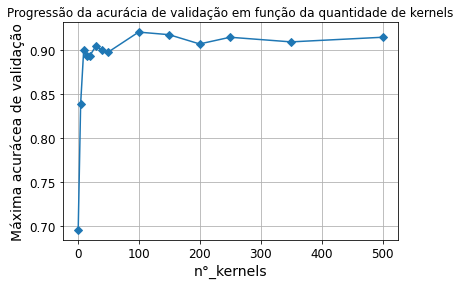

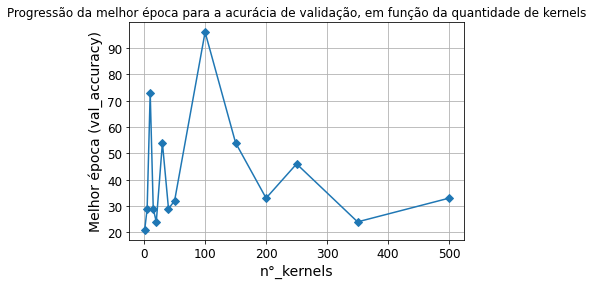

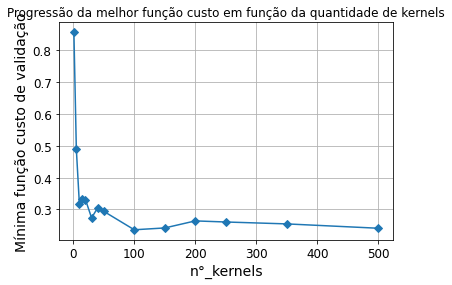

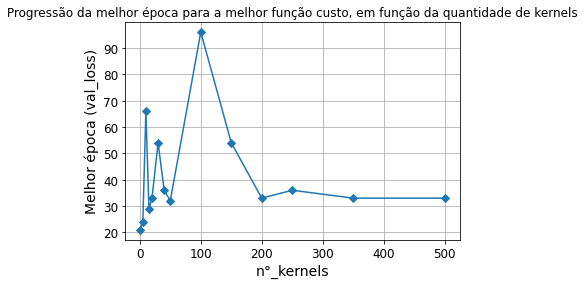

In [ ]:
print("Melhores valores da acurácia de validação, em função do número de kernels:")
print(best_val_acc)
print(n_kernels)
print("Melhores valores da função custo para a validação, em função do número de kernels:")
print(best_val_loss)
# Plotando os valores das melhores acurácias de validação em função da quantidade de kernels
plt.plot(n_kernels, best_val_acc, marker='D')
plt.grid(True)
plt.title("Progressão da acurácia de validação em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Máxima acurácea de validação")
plt.show()

# Plotando os valores das melhores épocas para a acurácia de validação em função da quantidade de kernels
plt.plot(n_kernels, best_epoch_acc, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a acurácia de validação, em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Melhor época (val_accuracy)")
plt.show()

# Plotando os valores dos menores valores do custo em função da quantidade de kernels
plt.plot(n_kernels, best_val_loss, marker='D')
plt.grid(True)
plt.title("Progressão da melhor função custo em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Mínima função custo de validação")
plt.show()

# Plotando os valores das melhores épocas para os menores valores do custo em função da quantidade de kernels
plt.plot(n_kernels, best_epoch_loss, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a melhor função custo, em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Melhor época (val_loss)")
plt.show()

- Avaliação da influência do tamanho do kernel na acurácia dos dados de validação:


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 2


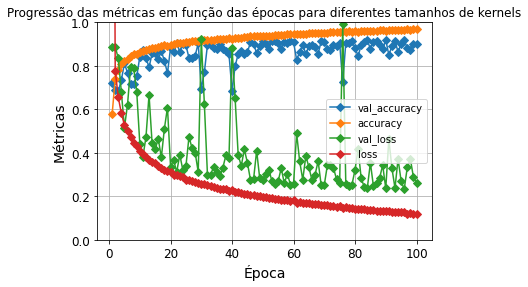

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 3


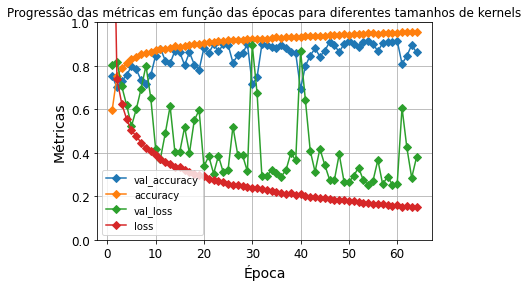

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 5


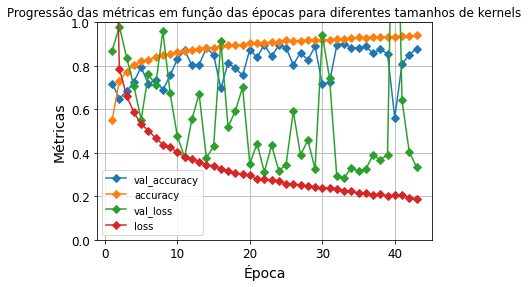

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 7


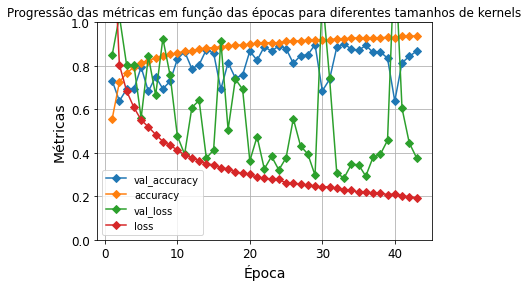

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 9


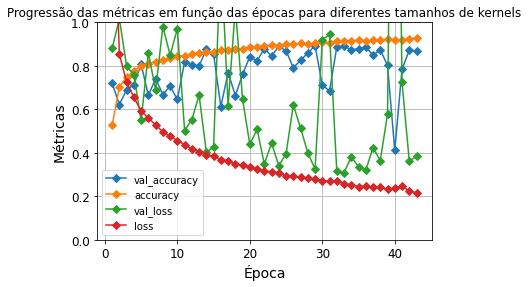

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 11


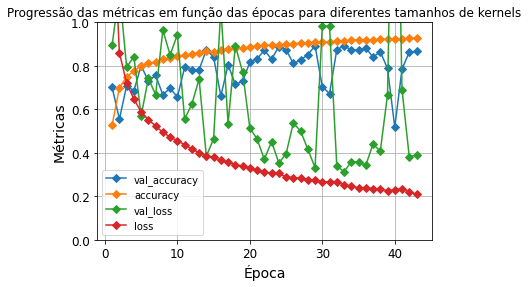

In [ ]:
# O segundo treinamento foi feito fixando todos os parâmetros e variando o tamanho dos kernels
# Valores de número de kernels a serem testados:
kernel_s = [2,3,5,7,9,11]
# Vetor das melhores acurácias de validação
best_val_acc2 = []
best_val_loss2 = []
# Vetor das respectivas épocas das melhores acurácias
best_epoch_acc2 = []
best_epoch_loss2 = []
for k in np.arange(0,len(kernel_s),1):
  # Construção da CNN
  # definindo o modelo:
  sCNN_model = keras.models.Sequential()
  # Definição da camada convolucional:
  sCNN_model.add(keras.layers.Conv2D(
                  # Será testado pelo KerasTuner diferentes quantidades de kernels
                  filters= 100, # Número de Kernels fixado para o melhor caso do item anterior (maior acurácia de validação em 100 kernels)
                  kernel_size = (kernel_s[k],kernel_s[k]), # Tamanho dos kernels 
                  strides=(1,1), # Stride unitário ao logo das duas dimensões da imagem (imagem com poucos pixels)
                  input_shape=[28, 28, 3], # Formato das imagens de entrada [linhas, colunas, canais]
                  padding='same', # Default='valid',"same" faz o zero padding e quando o stride é unitário mantém as dimensões da imagem
                  data_format=None, # Default=None, canais por último no formato de entrada
                  dilation_rate=(1, 1), # Default=(1, 1), sem dilatação da convolução
                  groups=1, # Default=1, apenas um grupo para as entradas
                  activation='relu', # Função de ativação ReLu
                  use_bias=True, # Default=True. Utilizando bias no modelo
                  kernel_initializer='he_uniform', # Default='glorot_uniform'. Modo de inicialização do pesos definido como he_uniform
                  bias_initializer='zeros', # Default='zeros'. Inicia o bias como zero
                  kernel_regularizer=None, # Default=None. Não utiliza regularização
                  bias_regularizer=None, # Default=None. Não utiliza regularização do bias 
                  activity_regularizer=None, # Default=None. Sem função de regularização na saída
                  kernel_constraint=None, # Default=None. Sem Constraint function (definições para os valores dos pesos) no Kernel
                  bias_constraint=None, # Default=Non. Sem Constraint function (definições para os valores dos pesos) no vetor de bias
                  name='2D-Convolutional-Layer') # nome da camada
                ) 
  # Definição da camada de pooling (Foi escolhido o Max Pooling)
  sCNN_model.add(keras.layers.MaxPool2D(pool_size=(2,2), # Default=(2,2). Tamanho da janela de pooling definida como 2x2
                      strides=(1,1), # Definição do stride das janelas de pooling como unitário
                      padding='valid', # Default='valid'. Sem padding
                      data_format=None, # Default=None. Canais por último no formato de entrada
                      name='2D-MaxPool-Layer') # nome da camada
                ) 
  # Definição da camada flatten antes da camada densa
  sCNN_model.add(keras.layers.Flatten(name='Flatten-Layer'))
  # Definição da camada densa de saída do tipo softmax
  sCNN_model.add(keras.layers.Dense(8, activation='softmax', name='Output-Layer'))

  # Compilação do modelo
  sCNN_model.compile(optimizer='sgd', # Otimizador sgd escolhido para o treinamento
                    loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                    metrics=['accuracy'], # A acurácia foi utilizada como métrica
                    )

  # fit do modelo
  sCNN_history = sCNN_model.fit(x_train, # dados de entrada
                    y_train, # labels do treinamento
                    batch_size=50, # Tamanho do batch para o treinamento (quantas amostras usa por vez)
                    epochs=100, # Número de épocas (quantas vezes percorre todos os dados)
                    verbose=0, # Grau de informações printadas
                    callbacks= keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), # Adição de Early Stopping para evitar overfitting
                    validation_data=(x_valid, y_valid) # Dados de validação  
                    )
  print(sCNN_history.history.keys())
  # Salvando os valores das melhores acurácias de validação e as melhores épocas para este parâmetro
  best_val_acc2.append(np.max(sCNN_history.history['val_accuracy']))
  best_epoch_acc2.append(sCNN_history.history['val_accuracy'].index(np.max(sCNN_history.history['val_accuracy']))+1)
  # Salvando os melhores valores da função custo e as melhores épocas para este parâmetro
  best_val_loss2.append(np.min(sCNN_history.history['val_loss']))
  best_epoch_loss2.append(sCNN_history.history['val_loss'].index(np.min(sCNN_history.history['val_loss']))+1)
  # Indica o tamnho do kernel utilizado
  print("Para kernel de tamanho =", kernel_s[k])  
  # Plotando os gráficos das métricas em função das épocas
  plt.plot(np.arange(1,len(sCNN_history.history['val_accuracy'])+1,1),sCNN_history.history['val_accuracy'], marker='D', label='val_accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['accuracy'])+1,1),sCNN_history.history['accuracy'], marker='D', label='accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['val_loss'])+1,1),sCNN_history.history['val_loss'], marker='D', label='val_loss')
  plt.plot(np.arange(1,len(sCNN_history.history['loss'])+1,1),sCNN_history.history['loss'], marker='D', label='loss')
  plt.gca().set_ylim(0, 1)
  plt.legend()
  plt.grid(True)
  plt.title("Progressão das métricas em função das épocas para diferentes tamanhos de kernels")
  plt.xlabel("Época")
  plt.ylabel("Métricas")
  plt.show()


Melhores valores da acurácia de validação, em função do tamanho do kernel:
[0.9193925261497498, 0.9153037667274475, 0.9001168012619019, 0.9007009267807007, 0.8925233483314514, 0.8919392228126526]
Melhores valores da função custo para a validação, em função do tamanho do kernel:
[0.2323637753725052, 0.25321483612060547, 0.2840963304042816, 0.28419792652130127, 0.3077225387096405, 0.31247055530548096]


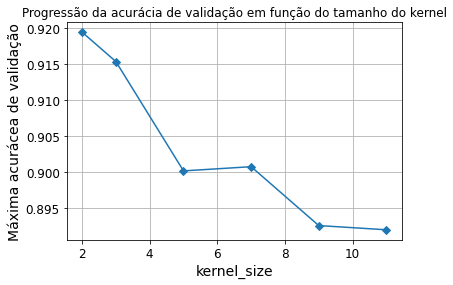

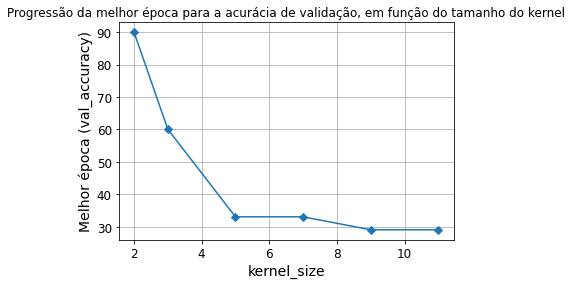

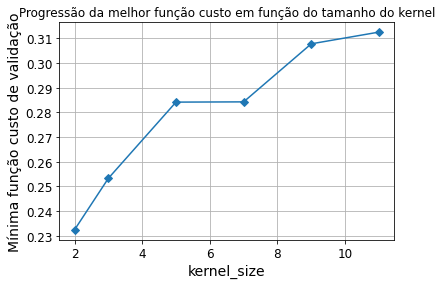

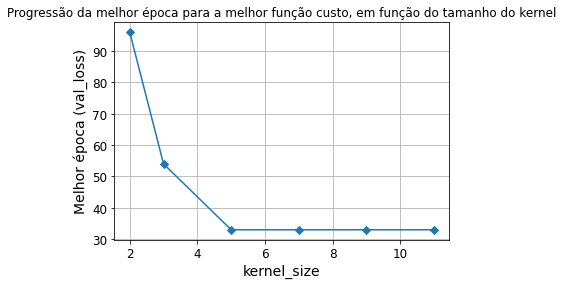

In [ ]:
print("Melhores valores da acurácia de validação, em função do tamanho do kernel:")
print(best_val_acc2)
print("Melhores valores da função custo para a validação, em função do tamanho do kernel:")
print(best_val_loss2)
# Plotando os valores das melhores acurácias de validação em função do tamanho do kernel
plt.plot(kernel_s, best_val_acc2, marker='D')
plt.grid(True)
plt.title("Progressão da acurácia de validação em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Máxima acurácea de validação")
plt.show()

# Plotando os valores das melhores épocas para a acurácia de validação em função da quantidade de kernels
plt.plot(kernel_s, best_epoch_acc2, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a acurácia de validação, em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Melhor época (val_accuracy)")
plt.show()

# Plotando os valores dos menores valores do custo em função da quantidade de kernels
plt.plot(kernel_s, best_val_loss2, marker='D')
plt.grid(True)
plt.title("Progressão da melhor função custo em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Mínima função custo de validação")
plt.show()

# Plotando os valores das melhores épocas para os menores valores do custo em função da quantidade de kernels
plt.plot(kernel_s, best_epoch_loss2, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a melhor função custo, em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Melhor época (val_loss)")
plt.show()

Variação de hiperparâmetros para encontrar o modelo ótimo:

In [ ]:
def CNN_build_model(hp):
  sCNN_model = keras.models.Sequential()
  # Definição da camada convolucional:
  sCNN_model.add(keras.layers.Conv2D(
                  # Será testado pelo KerasTuner diferentes quantidades de kernels
                  filters=hp.Int("filters", min_value=90, max_value=110, step=10), # camada intermediária , # Número de Kernels 
                  kernel_size=hp.Int("size", min_value=1, max_value=3, step=1), # Tamanho dos kernels fixado em 3x3
                  strides=hp.Int("stride", min_value=1, max_value=2, step=1), # Stride unitário ao logo das duas dimensões da imagem (imagem com poucos pixels)
                  input_shape=[28, 28, 3], # Formato das imagens de entrada [linhas, colunas, canais]
                  padding='same', # Default='valid',"same" faz o zero padding e quando o stride é unitário mantém as dimensões da imagem
                  data_format=None, # Default=None, canais por último no formato de entrada
                  dilation_rate=(1, 1), # Default=(1, 1), sem dilatação da convolução
                  groups=1, # Default=1, apenas um grupo para as entradas
                  activation='relu', # Função de ativação ReLu
                  use_bias=True, # Default=True. Utilizando bias no modelo
                  kernel_initializer='he_uniform', # Default='glorot_uniform'. Modo de inicialização do pesos definido como he_uniform
                  bias_initializer='zeros', # Default='zeros'. Inicia o bias como zero
                  kernel_regularizer=None, # Default=None. Não utiliza regularização
                  bias_regularizer=None, # Default=None. Não utiliza regularização do bias 
                  activity_regularizer=None, # Default=None. Sem função de regularização na saída
                  kernel_constraint=None, # Default=None. Sem Constraint function (definições para os valores dos pesos) no Kernel
                  bias_constraint=None, # Default=Non. Sem Constraint function (definições para os valores dos pesos) no vetor de bias
                  name='2D-Convolutional-Layer') # nome da camada
                ) 
  # Definição da camada de pooling (Foi escolhido o Max Pooling)
  sCNN_model.add(keras.layers.MaxPool2D(pool_size=(2,2), # Default=(2,2). Tamanho da janela de pooling definida como 2x2
                      strides=(1,1), # Definição do stride das janelas de pooling como unitário
                      padding='valid', # Default='valid'. Sem padding
                      data_format=None, # Default=None. Canais por último no formato de entrada
                      name='2D-MaxPool-Layer') # nome da camada
                ) 
  # Definição da camada flatten antes da camada densa
  sCNN_model.add(keras.layers.Flatten(name='Flatten-Layer'))
  # Definição da camada densa de saída do tipo softmax
  sCNN_model.add(keras.layers.Dense(8, activation='softmax', name='Output-Layer'))
  lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  # Compilação do modelo
  sCNN_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr), # Otimizador sgd escolhido para o treinamento
                    loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                    metrics=['accuracy'], # A acurácia foi utilizada como métrica
                    )
  return sCNN_model

CNN_build_model(keras_tuner.HyperParameters())

In [ ]:
sCNN_tuner = keras_tuner.BayesianOptimization(
    hypermodel=CNN_build_model,
    objective="val_accuracy",
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True
)
sCNN_tuner.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 90, 'max_value': 110, 'step': 10, 'sampling': None}
size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
stride (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}


In [ ]:
sCNN_tuner.search(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)])

Trial 10 Complete [00h 01m 24s]
val_accuracy: 0.9117990732192993

Best val_accuracy So Far: 0.9164719581604004
Total elapsed time: 00h 24m 34s


In [ ]:
# 2 melhores modelos
modelsCNN = sCNN_tuner.get_best_models(num_models=2)
best_model_CNN = modelsCNN[0]
# Build do modelo.
best_model_CNN.build(input_shape=(None, 28, 28))
best_model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2D-Convolutional-Layer (Con  (None, 28, 28, 90)       2520      
 v2D)                                                            
                                                                 
 2D-MaxPool-Layer (MaxPoolin  (None, 27, 27, 90)       0         
 g2D)                                                            
                                                                 
 Flatten-Layer (Flatten)     (None, 65610)             0         
                                                                 
 Output-Layer (Dense)        (None, 8)                 524888    
                                                                 
Total params: 527,408
Trainable params: 527,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sCNN_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
filters: 90
size: 3
lr: 0.01
stride: 1
Score: 0.9164719581604004
Trial summary
Hyperparameters:
filters: 100
size: 2
lr: 0.01
stride: 1
Score: 0.9117990732192993
Trial summary
Hyperparameters:
filters: 110
size: 3
lr: 0.01
stride: 2
Score: 0.9106308221817017
Trial summary
Hyperparameters:
filters: 110
size: 3
lr: 0.005906654353027764
stride: 1
Score: 0.9094626307487488
Trial summary
Hyperparameters:
filters: 110
size: 1
lr: 0.01
stride: 1
Score: 0.9065420627593994
Trial summary
Hyperparameters:
filters: 90
size: 3
lr: 0.01
stride: 2
Score: 0.9012850522994995
Trial summary
Hyperparameters:
filters: 90
size: 1
lr: 0.01
stride: 2
Score: 0.8878504633903503
Trial summary
Hyperparameters:
filters: 110
size: 1
lr: 0.01
stride: 2
Score: 0.8814252614974976
Trial summary
Hyperparameters:
filters: 90
size: 2
lr: 0.0007564197611404533
stride: 1
Score: 0.8709112405776978
Trial summary
Hyperparameters

## Teste do melhor modelo da CNN simples

- Retreinamento com os hiperparâmetros ótimos

Epoch 1/100
274/274 - 2s - loss: 2.0005 - accuracy: 0.6046 - 2s/epoch - 7ms/step
Epoch 2/100
274/274 - 1s - loss: 0.7243 - accuracy: 0.7536 - 1s/epoch - 4ms/step
Epoch 3/100
274/274 - 1s - loss: 0.5989 - accuracy: 0.7991 - 1s/epoch - 5ms/step
Epoch 4/100
274/274 - 1s - loss: 0.5390 - accuracy: 0.8179 - 1s/epoch - 4ms/step
Epoch 5/100
274/274 - 2s - loss: 0.4877 - accuracy: 0.8378 - 2s/epoch - 6ms/step
Epoch 6/100
274/274 - 2s - loss: 0.4571 - accuracy: 0.8466 - 2s/epoch - 6ms/step
Epoch 7/100
274/274 - 2s - loss: 0.4312 - accuracy: 0.8573 - 2s/epoch - 6ms/step
Epoch 8/100
274/274 - 2s - loss: 0.4109 - accuracy: 0.8615 - 2s/epoch - 6ms/step
Epoch 9/100
274/274 - 1s - loss: 0.3914 - accuracy: 0.8704 - 1s/epoch - 5ms/step
Epoch 10/100
274/274 - 1s - loss: 0.3805 - accuracy: 0.8718 - 1s/epoch - 4ms/step
Epoch 11/100
274/274 - 1s - loss: 0.3594 - accuracy: 0.8797 - 1s/epoch - 4ms/step
Epoch 12/100
274/274 - 1s - loss: 0.3487 - accuracy: 0.8853 - 1s/epoch - 4ms/step
Epoch 13/100
274/274 - 1s

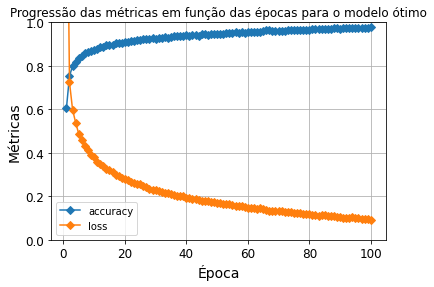

In [ ]:
# Retreinando a rede para os parâmetros ótimos
# Construção da CNN
# definindo o modelo:
sCNN_model = keras.models.Sequential()
# Definição da camada convolucional:
sCNN_model.add(keras.layers.Conv2D(
                # Será testado pelo KerasTuner diferentes quantidades de kernels
                filters= 90, # Número de Kernels fixado para o melhor caso do item anterior (maior acurácia de validação em 100 kernels)
                kernel_size = (3,3), # Tamanho dos kernels fixado para o valor ótimo obtido anteriormente (2x2)
                strides=(1,1), # Stride unitário ao logo das duas dimensões da imagem (imagem com poucos pixels)
                input_shape=[28, 28, 3], # Formato das imagens de entrada [linhas, colunas, canais]
                padding='same', # Default='valid',"same" faz o zero padding e quando o stride é unitário mantém as dimensões da imagem
                data_format=None, # Default=None, canais por último no formato de entrada
                dilation_rate=(1, 1), # Default=(1, 1), sem dilatação da convolução
                groups=1, # Default=1, apenas um grupo para as entradas
                activation='relu', # Função de ativação ReLu
                use_bias=True, # Default=True. Utilizando bias no modelo
                kernel_initializer='he_uniform', # Default='glorot_uniform'. Modo de inicialização do pesos definido como he_uniform
                bias_initializer='zeros', # Default='zeros'. Inicia o bias como zero
                kernel_regularizer=None, # Default=None. Não utiliza regularização
                bias_regularizer=None, # Default=None. Não utiliza regularização do bias 
                activity_regularizer=None, # Default=None. Sem função de regularização na saída
                kernel_constraint=None, # Default=None. Sem Constraint function (definições para os valores dos pesos) no Kernel
                bias_constraint=None, # Default=Non. Sem Constraint function (definições para os valores dos pesos) no vetor de bias
                name='2D-Convolutional-Layer') # nome da camada
              ) 
# Definição da camada de pooling (Foi escolhido o Max Pooling)
sCNN_model.add(keras.layers.MaxPool2D(pool_size=(2,2), # Default=(2,2). Tamanho da janela de pooling definida como 2x2
                    strides=(1,1), # Definição do stride das janelas de pooling como unitário
                    padding='valid', # Default='valid'. Sem padding
                    data_format=None, # Default=None. Canais por último no formato de entrada
                    name='2D-MaxPool-Layer') # nome da camada
              ) 
# Definição da camada flatten antes da camada densa
sCNN_model.add(keras.layers.Flatten(name='Flatten-Layer'))
# Definição da camada densa de saída do tipo softmax
sCNN_model.add(keras.layers.Dense(8, activation='softmax', name='Output-Layer'))

# Compilação do modelo
sCNN_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), # Otimizador sgd escolhido para o treinamento
                  loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                  metrics=['accuracy'], # A acurácia foi utilizada como métrica
                  )

# fit do modelo
sCNN_history = sCNN_model.fit(x_tv, # dados de entrada de treinamento + validação
                  y_tv, # labels do treinamento + validação
                  batch_size=50, # Tamanho do batch para o treinamento (quantas amostras usa por vez)
                  epochs=100, # Número de épocas (quantas vezes percorre todos os dados)
                  verbose=2, # Grau de informações printadas
                  callbacks= None,
                  validation_data = None  
                  )
print(sCNN_history.history.keys())
# Plotando os gráficos das métricas em função das épocas
plt.plot(np.arange(1,len(sCNN_history.history['accuracy'])+1,1),sCNN_history.history['accuracy'], marker='D', label='accuracy')
plt.plot(np.arange(1,len(sCNN_history.history['loss'])+1,1),sCNN_history.history['loss'], marker='D', label='loss')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.grid(True)
plt.title("Progressão das métricas em função das épocas para o modelo ótimo")
plt.xlabel("Época")
plt.ylabel("Métricas")
plt.show()

- Acurácia Global e demais métricas

In [ ]:
# Resumo do modelo
print("Model summary")
sCNN_model.summary() # print model summary
print("")

# Model Evaluation
print("Model Evaluation")
sCNN_test = sCNN_model.evaluate(x_test, y_test)
print("A acurácia global para os dados de teste obtida foi de 0.9182")



Model summary
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2D-Convolutional-Layer (Con  (None, 28, 28, 90)       2520      
 v2D)                                                            
                                                                 
 2D-MaxPool-Layer (MaxPoolin  (None, 27, 27, 90)       0         
 g2D)                                                            
                                                                 
 Flatten-Layer (Flatten)     (None, 65610)             0         
                                                                 
 Output-Layer (Dense)        (None, 8)                 524888    
                                                                 
Total params: 527,408
Trainable params: 527,408
Non-trainable params: 0
_________________________________________________________________

Model Evaluation
107/107 [=======

In [ ]:
# Valores previstos:
y_pred_sCNN = np.array(tf.math.argmax(sCNN_model.predict(x_test),axis=1))
# Resultados da previsão:
print(metrics.classification_report(y_test, y_pred_sCNN))

107/107 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       244
           1       0.98      0.96      0.97       624
           2       0.92      0.94      0.93       311
           3       0.86      0.79      0.82       579
           4       0.90      0.89      0.89       243
           5       0.77      0.85      0.81       284
           6       0.95      0.97      0.96       666
           7       0.99      1.00      1.00       470

    accuracy                           0.92      3421
   macro avg       0.91      0.91      0.91      3421
weighted avg       0.92      0.92      0.92      3421



- Matriz de Confusão para os dados de teste

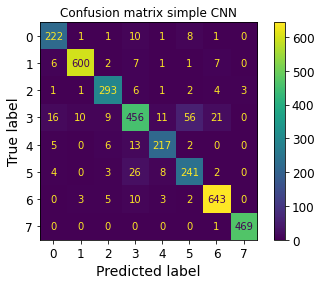

In [ ]:
# Matriz de confusão
sCNN_cm=metrics.confusion_matrix(y_test, y_pred_sCNN )
cm_fig=metrics.ConfusionMatrixDisplay(confusion_matrix=sCNN_cm)
cm_fig.plot()
plt.title('Confusion matrix simple CNN')
plt.show()

- Cinco padrões de teste que foram classificados incorretamente, indicando a classe esperada e as probabilidades estimadas pela rede

Para a amostra 0  do conjunto de teste:
Classe esperada: 3
Classe estimada: 5
Imagem:


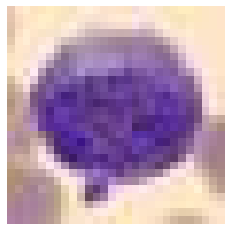


Probabilidades:
1/1 [==============================] - 0s 65ms/step
Classe 0: 0.009904365
Classe 1: 9.102318e-06
Classe 2: 1.9106017
Classe 3: 1.5989952
Classe 4: 0.2887364
Classe 5: 96.19151
Classe 6: 0.00024056192
Classe 7: 3.4057308e-08

---------------------------------------------------------------------------------------------

Para a amostra 16  do conjunto de teste:
Classe esperada: 4
Classe estimada: 2
Imagem:


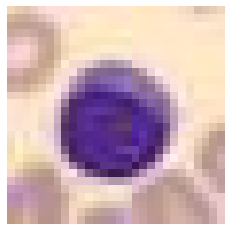


Probabilidades:
1/1 [==============================] - 0s 21ms/step
Classe 0: 0.44415992
Classe 1: 0.0029062098
Classe 2: 50.93937
Classe 3: 30.60504
Classe 4: 17.232742
Classe 5: 0.7516879
Classe 6: 0.023349516
Classe 7: 0.00074288755

---------------------------------------------------------------------------------------------

Para a amostra 23  do conjunto de teste:
Classe esperada: 5
Classe estimada: 4
Imagem:


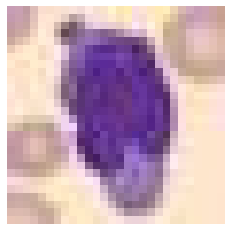


Probabilidades:
1/1 [==============================] - 0s 20ms/step
Classe 0: 0.5439885
Classe 1: 0.000488516
Classe 2: 0.011223123
Classe 3: 1.0416981
Classe 4: 64.75161
Classe 5: 33.649986
Classe 6: 0.0009743778
Classe 7: 3.2314736e-05

---------------------------------------------------------------------------------------------

Para a amostra 25  do conjunto de teste:
Classe esperada: 6
Classe estimada: 2
Imagem:


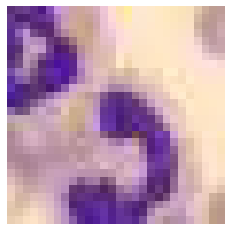


Probabilidades:
1/1 [==============================] - 0s 18ms/step
Classe 0: 0.0029320428
Classe 1: 2.533782
Classe 2: 89.58534
Classe 3: 7.674213
Classe 4: 0.041696224
Classe 5: 0.0024306327
Classe 6: 0.055680547
Classe 7: 0.10393067

---------------------------------------------------------------------------------------------

Para a amostra 28  do conjunto de teste:
Classe esperada: 3
Classe estimada: 5
Imagem:


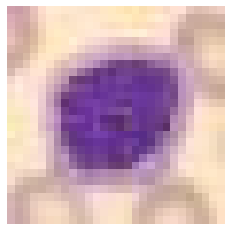


Probabilidades:
1/1 [==============================] - 0s 19ms/step
Classe 0: 0.17828101
Classe 1: 0.005472714
Classe 2: 0.005601187
Classe 3: 39.424656
Classe 4: 1.8304726
Classe 5: 58.353943
Classe 6: 0.19899848
Classe 7: 0.0025776802

---------------------------------------------------------------------------------------------



In [ ]:
classes = [0,1,2,3,4,5,6,7]
error = []
# Identifica os índices das 5 primeiras labels previstas de forma errada
for j in range(0,len(y_pred_sCNN),1):
  if y_pred_sCNN[j] != y_test[j]:
    error.append(j)
    error = error[:5]
# Mostra a classe obtida, a classe esperada e as probabilidades para os 5 primeiros erros
for index in range(0,len(error),1):
  print("Para a amostra", error[index]," do conjunto de teste:")
  print("Classe esperada:",y_test[error[index]])
  print("Classe estimada:",y_pred_sCNN[error[index]])
  print("Imagem:")
  plt.imshow(test_img[error[index]],cmap="gray")
  plt.axis("off")
  plt.show()
  print("")
  print("Probabilidades:")
  x_teste= tf.expand_dims(x_test[error[index]], 0)  # Create batch axis
  prob = sCNN_model.predict(x_teste)*100
  print("Classe 0:", prob[0][0])
  print("Classe 1:", prob[0][1])
  print("Classe 2:", prob[0][2])
  print("Classe 3:", prob[0][3])
  print("Classe 4:", prob[0][4])
  print("Classe 5:", prob[0][5])
  print("Classe 6:", prob[0][6])
  print("Classe 7:", prob[0][7])
  print("")
  print("---------------------------------------------------------------------------------------------")
  print("")


## Treinamento e validação da CNN complexa (inspirada na ResNet)

In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)
# Unidade Residual
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
# Modelo inspirado na ResNet
ResNet_model = keras.models.Sequential()
ResNet_model.add(DefaultConv2D(64, kernel_size=3, strides=1, input_shape=[28, 28, 3]))
ResNet_model.add(keras.layers.BatchNormalization())
ResNet_model.add(keras.layers.Activation("relu"))
ResNet_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64]  + [128] +  [256]:
    strides = 1 if filters == prev_filters else 2
    ResNet_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
#ResNet_model.add()
ResNet_model.add(keras.layers.GlobalAvgPool2D())
ResNet_model.add(keras.layers.Flatten())
ResNet_model.add(keras.layers.Dense(1000, activation="relu")) # camada intermediária 
ResNet_model.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
ResNet_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 28, 28, 64)        1728      
                                                                 
 batch_normalization_110 (Ba  (None, 28, 28, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 residual_unit_39 (ResidualU  (None, 14, 14, 64)       74240     
 nit)                                                            
                                                     

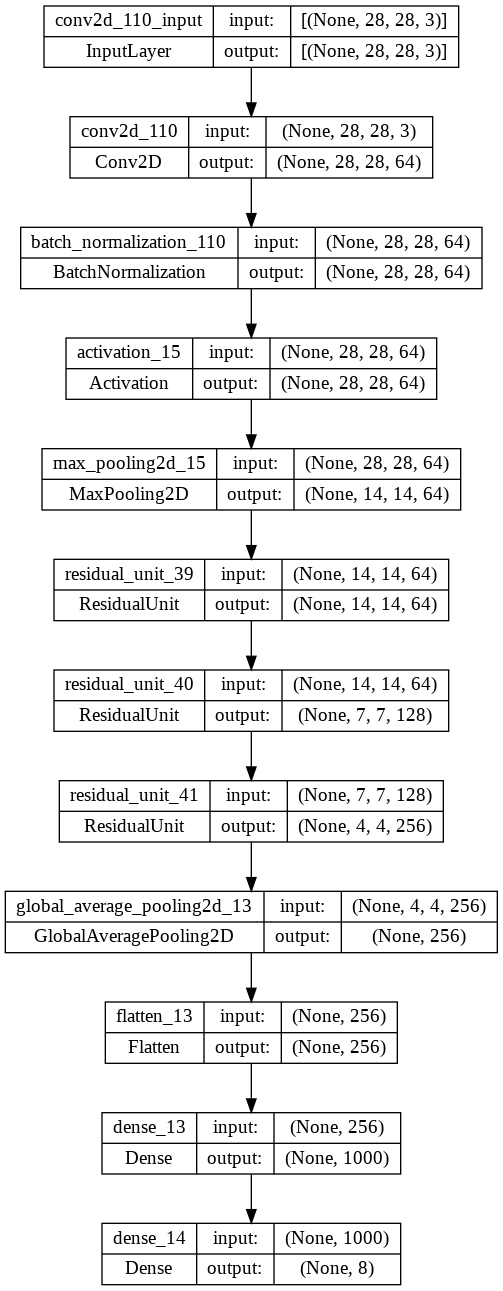

In [ ]:
keras.utils.plot_model(ResNet_model, "model.png", show_shapes=True)

Epoch 1/100
240/240 - 5s - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.2944 - val_accuracy: 0.9276 - 5s/epoch - 22ms/step
Epoch 2/100
240/240 - 3s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.2138 - val_accuracy: 0.9504 - 3s/epoch - 12ms/step
Epoch 3/100
240/240 - 3s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2174 - val_accuracy: 0.9498 - 3s/epoch - 11ms/step
Epoch 4/100
240/240 - 3s - loss: 7.4891e-04 - accuracy: 1.0000 - val_loss: 0.2048 - val_accuracy: 0.9463 - 3s/epoch - 11ms/step
Epoch 5/100
240/240 - 3s - loss: 9.1693e-04 - accuracy: 0.9999 - val_loss: 0.2113 - val_accuracy: 0.9451 - 3s/epoch - 11ms/step
Epoch 6/100
240/240 - 3s - loss: 6.9377e-04 - accuracy: 1.0000 - val_loss: 0.2407 - val_accuracy: 0.9457 - 3s/epoch - 11ms/step
Epoch 7/100
240/240 - 3s - loss: 6.4171e-04 - accuracy: 1.0000 - val_loss: 0.2187 - val_accuracy: 0.9474 - 3s/epoch - 12ms/step
Epoch 8/100
240/240 - 3s - loss: 5.7884e-04 - accuracy: 1.0000 - val_loss: 0.4819 - val_accuracy: 0.9095 - 3s/epoch 

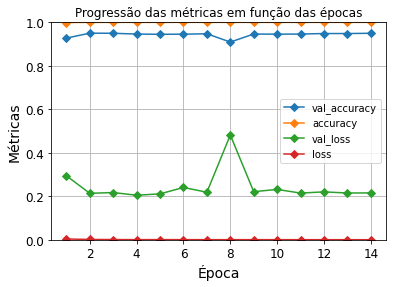

In [ ]:
# Treinamento:
# Compilação do modelo
ResNet_model.compile(optimizer='sgd', # Otimizador sgd escolhido para o treinamento
                  loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                  metrics=['accuracy'], # A acurácia foi utilizada como métrica
                  )

# fit do modelo
ResNet_history = ResNet_model.fit(x_train, # dados de entrada de treinamento + validação
                  y_train, # labels do treinamento + validação
                  batch_size=50, # Tamanho do batch para o treinamento (quantas amostras usa por vez)
                  epochs=100, # Número de épocas (quantas vezes percorre todos os dados)
                  verbose=2, # Grau de informações printadas
                  callbacks= keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), # Adição de Early Stopping para evitar overfitting,
                  validation_data = (x_valid, y_valid) 
                  )
  # Plotando os gráficos das métricas em função das épocas
plt.plot(np.arange(1,len(ResNet_history.history['val_accuracy'])+1,1),ResNet_history.history['val_accuracy'], marker='D', label='val_accuracy')
plt.plot(np.arange(1,len(ResNet_history.history['accuracy'])+1,1),ResNet_history.history['accuracy'], marker='D', label='accuracy')
plt.plot(np.arange(1,len(ResNet_history.history['val_loss'])+1,1),ResNet_history.history['val_loss'], marker='D', label='val_loss')
plt.plot(np.arange(1,len(ResNet_history.history['loss'])+1,1),ResNet_history.history['loss'], marker='D', label='loss')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.grid(True)
plt.title("Progressão das métricas em função das épocas")
plt.xlabel("Época")
plt.ylabel("Métricas")
plt.show()

## Teste do melhor modelo da CNN complexa (inspirada na ResNet)


- Acurácia Global e demais métricas

In [ ]:
# Model Evaluation
print("Model Evaluation")
ResNet_test = ResNet_model.evaluate(x_test, y_test)
print("A acurácia global para os dados de teste obtida foi de 0.9547")

Model Evaluation
107/107 [==============================] - 1s 5ms/step - loss: 0.2039 - accuracy: 0.9547
A acurácia global para os dados de teste obtida foi de 0.9547


In [ ]:
# Valores previstos:
y_pred_ResNet = np.array(tf.math.argmax(ResNet_model.predict(x_test),axis=1))
# Resultados da previsão:
print(metrics.classification_report(y_test, y_pred_ResNet))

107/107 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       244
           1       1.00      0.99      0.99       624
           2       0.97      0.95      0.96       311
           3       0.89      0.89      0.89       579
           4       0.95      0.95      0.95       243
           5       0.91      0.89      0.90       284
           6       0.96      0.97      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.95      3421
   macro avg       0.95      0.95      0.95      3421
weighted avg       0.95      0.95      0.95      3421



- Matriz de Confusão para os dados de teste

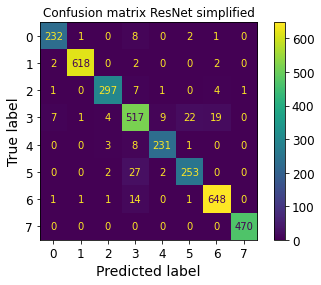

In [ ]:
# Matriz de confusão
ResNet_cm=metrics.confusion_matrix(y_test, y_pred_ResNet)
cm_fig_RN=metrics.ConfusionMatrixDisplay(confusion_matrix=ResNet_cm)
cm_fig_RN.plot()
plt.title('Confusion matrix ResNet simplified')
plt.show()

- Cinco padrões de teste que foram classificados incorretamente, indicando a classe esperada e as probabilidades estimadas pela rede

Para a amostra 0  do conjunto de teste:
Classe esperada: 3
Classe estimada: 5
Imagem:


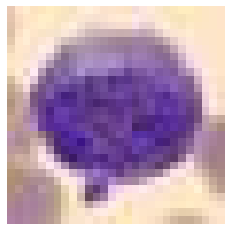


Probabilidades:
1/1 [==============================] - 0s 304ms/step
Classe 0: 3.735531e-05
Classe 1: 3.3815395e-05
Classe 2: 0.0001724188
Classe 3: 1.6459193
Classe 4: 2.7550828e-05
Classe 5: 98.35378
Classe 6: 4.3331534e-06
Classe 7: 2.6753472e-05

---------------------------------------------------------------------------------------------

Para a amostra 8  do conjunto de teste:
Classe esperada: 6
Classe estimada: 5
Imagem:


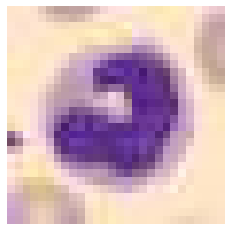


Probabilidades:
1/1 [==============================] - 0s 21ms/step
Classe 0: 0.00012944081
Classe 1: 9.001744e-05
Classe 2: 7.0161136e-06
Classe 3: 0.002072614
Classe 4: 0.00038341436
Classe 5: 99.862946
Classe 6: 0.13407616
Classe 7: 0.00030768575

---------------------------------------------------------------------------------------------

Para a amostra 65  do conjunto de teste:
Classe esperada: 0
Classe estimada: 3
Imagem:


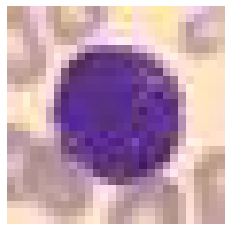


Probabilidades:
1/1 [==============================] - 0s 30ms/step
Classe 0: 0.4353825
Classe 1: 4.6896967e-05
Classe 2: 2.8362208e-05
Classe 3: 96.3673
Classe 4: 0.0014869403
Classe 5: 3.1957433
Classe 6: 1.2028274e-05
Classe 7: 7.6506385e-06

---------------------------------------------------------------------------------------------

Para a amostra 102  do conjunto de teste:
Classe esperada: 5
Classe estimada: 3
Imagem:


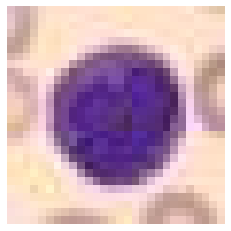


Probabilidades:
1/1 [==============================] - 0s 29ms/step
Classe 0: 2.3424675
Classe 1: 0.0009144098
Classe 2: 0.24019802
Classe 3: 75.586525
Classe 4: 0.12547007
Classe 5: 21.703043
Classe 6: 0.0011649994
Classe 7: 0.00021216176

---------------------------------------------------------------------------------------------

Para a amostra 118  do conjunto de teste:
Classe esperada: 2
Classe estimada: 7
Imagem:


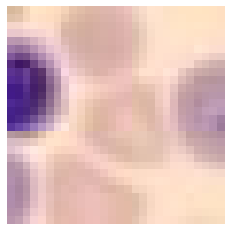


Probabilidades:
1/1 [==============================] - 0s 26ms/step
Classe 0: 5.584194e-05
Classe 1: 0.0063814563
Classe 2: 43.4769
Classe 3: 0.00017946854
Classe 4: 0.0013726496
Classe 5: 3.1206415e-05
Classe 6: 0.07708176
Classe 7: 56.438

---------------------------------------------------------------------------------------------



In [ ]:
classes = [0,1,2,3,4,5,6,7]
RN_error = []
# Identifica os índices das 5 primeiras labels previstas de forma errada
for j in range(0,len(y_pred_ResNet),1):
  if y_pred_ResNet[j] != y_test[j]:
    RN_error.append(j)
    RN_error = RN_error[:5]
# Mostra a classe obtida, a classe esperada e as probabilidades para os 5 primeiros erros
for index in range(0,len(RN_error),1):
  print("Para a amostra", RN_error[index]," do conjunto de teste:")
  print("Classe esperada:",y_test[RN_error[index]])
  print("Classe estimada:",y_pred_ResNet[RN_error[index]])
  print("Imagem:")
  plt.imshow(test_img[RN_error[index]],cmap="gray")
  plt.axis("off")
  plt.show()
  print("")
  print("Probabilidades:")
  x_RN= tf.expand_dims(x_test[RN_error[index]], 0)  # Create batch axis
  prob_RN = ResNet_model.predict(x_RN)*100
  print("Classe 0:", prob_RN[0][0])
  print("Classe 1:", prob_RN[0][1])
  print("Classe 2:", prob_RN[0][2])
  print("Classe 3:", prob_RN[0][3])
  print("Classe 4:", prob_RN[0][4])
  print("Classe 5:", prob_RN[0][5])
  print("Classe 6:", prob_RN[0][6])
  print("Classe 7:", prob_RN[0][7])
  print("")
  print("---------------------------------------------------------------------------------------------")
  print("")